Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [526]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from itertools import product
from random import random, randint, seed, sample
from scipy import sparse
from copy import copy
from functools import reduce
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import cdist

# Halloween Challenge

Find the best solution with the fewest calls to the fitness functions for:

* `num_points = [100, 1_000, 5_000]`
* `num_sets = num_points`
* `density = [.3, .7]` 

In [870]:
def make_set_covering_problem(num_points, num_sets, density):
    """Returns a sparse array where rows are sets and columns are the covered items"""
    seed(num_points * 2654435761 + num_sets + density)
    sets = sparse.lil_array((num_sets, num_points), dtype = bool)
    for s, p in product(range(num_sets), range(num_points)):
        if random() < density:
            sets[s, p] = True
    for p in range(num_points):
        sets[randint(0, num_sets - 1), p] = True
    return sets

n = 5000
PROBLEM_SIZE = NUM_SETS = n
x = make_set_covering_problem(n, n, .7)

SETS = x.toarray()
print("Element at row=42 and column=42:", x[1, 1])

Element at row=42 and column=42: True


## Cluster Random Cosine (100, 0.3)

In [ ]:
similarity_matrix = cosine_similarity(SETS * 1)

In [ ]:
sns.set()  
plt.figure(figsize=(8, 6))

sns.heatmap(similarity_matrix, cmap = "YlGnBu", annot = False, 
            square=True, cbar = True, xticklabels = False, yticklabels = False)

plt.xlabel("Sets")
plt.ylabel("Sets")
plt.show()

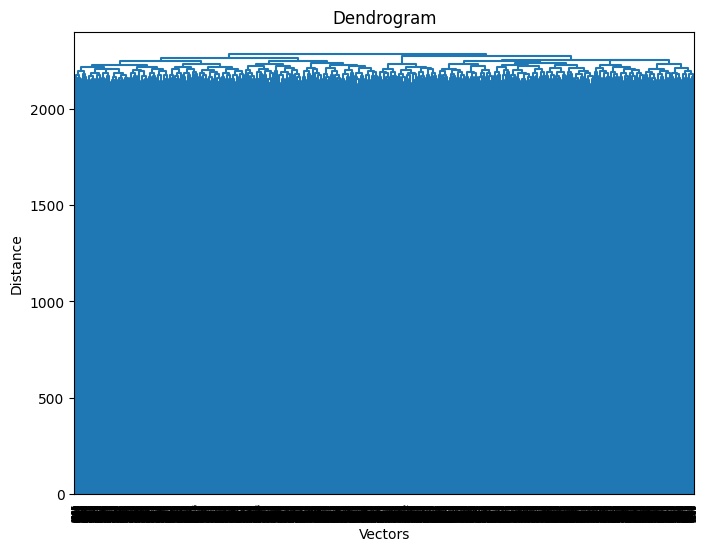

In [871]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Euclidean
# Cosine    not bad
# Manhattan Best

# Perform hierarchical clustering
linkage_matrix = linkage(SETS, method = 'complete', metric = 'cityblock')  # 1 - similarity for distance

# Plot the dendrogram (optional)
plt.figure(figsize=(8, 6))
dendrogram(linkage_matrix)
plt.title('Dendrogram')
plt.xlabel('Vectors')
plt.ylabel('Distance')
plt.show()

threshold = 2255  # Set a threshold for similarity
clusters = fcluster(linkage_matrix, threshold, criterion = 'distance')

In [986]:
# TRADE-OFF between cost and number of calls (0.3 density)
# threshold = 6.5   # missing_steps = 50    # n = 100
# threshold = 21.4  # missing_steps = 50    # n = 1000
# threshold = 47    # missing_steps = 100   # n = 5000

# TRADE-OFF between cost and number of calls (0.7 density)
threshold = 2250   # missing_steps = 50    # n = 100

clusters = fcluster(linkage_matrix, threshold, criterion = 'distance')

(array([1377.,  461.,  610.,    0.,  485.,  444.,    0.,  819.,  401.,
         403.]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 <BarContainer object of 10 artists>)

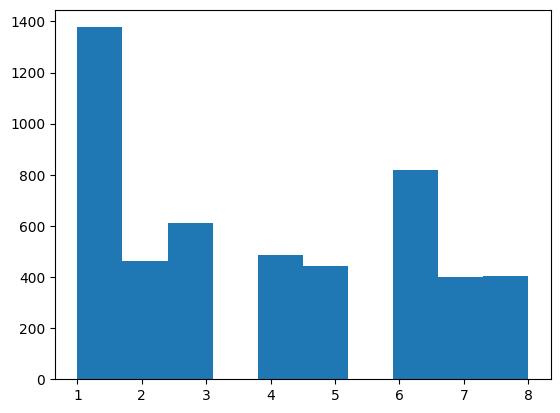

In [987]:
plt.hist(clusters, bins = 10)

In [988]:
from random import choice

dict_cluster_set = {clusters[i]:[] for i in range(PROBLEM_SIZE)}

for set in range(len(clusters)):
    dict_cluster_set[clusters[set]].append(set)

dict_cluster_weight = {}
for k, v in dict_cluster_set.items():
    val = sum(SETS[v]*1)/len(v)
    dict_cluster_weight[k] = val

# def tweak(state):
#     new_state = copy(state)
#     candidates = []
#     selected = []
#     for cluster in dict_cluster_set.keys():
#         chosen_one = choice(dict_cluster_set[cluster])
#         selected.append(chosen_one)
#         candidates.append(SETS[chosen_one])


#     return candidates, selected

# temp = [False for _ in range(PROBLEM_SIZE)]
# cand, chos = tweak(temp)

def fitness2(state):
    cost = sum(state)
    valid = np.sum(
        reduce(
            np.logical_or,
            [SETS[i] for i, t in enumerate(state) if t],
            np.array([False for _ in range(PROBLEM_SIZE)]),
        )
    )
    return valid, -cost

def tweak(state, index):
    new_state = copy(state)
    new_state[index] = not new_state[index]
    return new_state

def actual_solution(state): 
    vector = reduce(
            np.logical_or,
            [SETS[i] for i, t in enumerate(state) if t],
            np.array([False for _ in range(PROBLEM_SIZE)]),
        )
    return vector*1

In [1044]:
current_state = [False for _ in range(PROBLEM_SIZE)]
candidate_state = current_state
flag = False

print(fitness2(current_state))
count_fitness = 0
best_index = 0
missing_steps = 0

for step in range(10000):
    
    candidates = []
    selected = []

    # for each element in dict_cluster_weight, evaluate the manhattan distance with the actual solution

    clusters_to_select = []
    cs = actual_solution(current_state)
    for cluster in dict_cluster_weight.keys():
        # manhattan distance between two vectors 
        clusters_to_select.append((cluster,cdist([cs], [dict_cluster_weight[cluster]], metric = 'cityblock')[0][0]))

    # top n clusters 
    clusters_to_select = sorted(clusters_to_select, key = lambda x: x[1], reverse = True)[:int(len(clusters_to_select) * 2/4)]

    for name, value in clusters_to_select:
        chosen_one = choice(dict_cluster_set[name])  # Select a sample from the cluster.
        selected.append(chosen_one)                     # Append the selected sample.
        candidates.append(SETS[chosen_one])             # Append the select set.
    
    for i in range(len(candidates)):
        
        new_state = tweak(current_state, selected[i])
        
        count_fitness += 1
        if fitness2(new_state) > fitness2(candidate_state):
            candidate_state = new_state
            best_index = i
            print(step, count_fitness, fitness2(candidate_state))
            missing_steps = 0
        else:
            missing_steps += 1
    
        if missing_steps == 5:
            flag = True
            break
        
    if flag:
        break

    current_state = candidate_state   

print(fitness2(current_state))

print(count_fitness)

(0, 0)
0 1 (3507, -1)
0 3 (3530, -1)
0 4 (3567, -1)
1 5 (4537, -2)
1 6 (4568, -2)
1 7 (4572, -2)
2 9 (4871, -3)
2 10 (4884, -3)
2 11 (4886, -3)
3 13 (4958, -4)
3 14 (4959, -4)
3 15 (4971, -4)
4 17 (4991, -5)
4 18 (4992, -5)
5 21 (4997, -6)
5 23 (4999, -6)
5 24 (5000, -6)
(5000, -6)
29


(68, (5000, -6), 6, 40)

## Baseline

In [ ]:
def tweak(state):
    new_state = copy(state)
    index = randint(0, PROBLEM_SIZE - 1)
    new_state[index] = not new_state[index]
    return new_state

def fitness2(state):
    cost = sum(state)
    valid = np.sum(
        reduce(
            np.logical_or,
            [SETS[i] for i, t in enumerate(state) if t],
            np.array([False for _ in range(PROBLEM_SIZE)]),
        )
    )
    return valid, -cost

In [ ]:
current_state = [False for _ in range(PROBLEM_SIZE)]
print(fitness2(current_state))
count_fitness = 1
count_updates = 0
missing_steps = 0

for step in range(100_000):
    new_state = tweak(current_state)
    count_fitness += 1
    if fitness2(new_state) > fitness2(current_state):
        current_state = new_state
        count_updates += 1
        print(fitness2(current_state))
        missing_steps = 0
    else:
        missing_steps += 1
    
    if missing_steps == 1000:
        break
        
print('Count Fitness:', count_fitness)
print('Count Updates:', count_updates)

In [ ]:
# multiple experiments with different initial states
for i, elem in enumerate(initial_states):
    print(f'Initial state {i}')
    current_state = copy(elem)
    #print(current_state)
    #print(fitness2(current_state))
    count_fitness = 0
    for step in range(10_000):
        new_state = tweak(current_state)
        if fitness2(new_state) > fitness2(current_state):
            current_state = new_state
            count_fitness += 1
            #print(fitness2(current_state))
    print("final state fitness ", fitness2(current_state))
    print("count_fitness: ", count_fitness)
    print("End of iteration number ", i)
    print()

### Random N-1 Tweaking

In [ ]:
def tweak(state):
    new_state = copy(state)
    n_swapping = randint(0, PROBLEM_SIZE - 1)
    index_list = sample(range(0, PROBLEM_SIZE - 1), n_swapping)
    new_state = [not new_state[i] if i in index_list else new_state[i] for i in range(len(new_state))]
    return new_state

def fitness2(state):
    cost = sum(state)
    valid = np.sum(
        reduce(
            np.logical_or,
            [SETS[i] for i, t in enumerate(state) if t],
            np.array([False for _ in range(PROBLEM_SIZE)]),
        )
    )
    return valid, -cost

In [ ]:
current_state = [False for _ in range(PROBLEM_SIZE)]
print(current_state)
print(fitness2(current_state))
count_fitness = 0
count_updates = 0
missing_steps = 0

for step in range(10_000):
    new_state = tweak(current_state)
    count_fitness += 2
    if fitness2(new_state) > fitness2(current_state):
        current_state = new_state
        count_updates += 1
        print(fitness2(current_state))
        missing_steps = 0
    else:
        missing_steps += 1
    
    if missing_steps == 2000:
        break
        
print('Count Fitness:', count_fitness)
print('Count Updates:', count_updates)

### Random 2 Tweak

In [ ]:
def tweak(state):
    new_state = copy(state)
    index_list = sample(range(0, PROBLEM_SIZE - 1), 2)
    new_state = [not new_state[i] if i in index_list else new_state[i] for i in range(len(new_state))]
    return new_state

def fitness2(state):
    cost = sum(state)
    valid = np.sum(
        reduce(
            np.logical_or,
            [SETS[i] for i, t in enumerate(state) if t],
            np.array([False for _ in range(PROBLEM_SIZE)]),
        )
    )
    return valid, -cost

In [ ]:
current_state = [False for _ in range(PROBLEM_SIZE)]
print(fitness2(current_state))
count_fitness = 0
count_updates = 0
missing_steps = 0

for step in range(10_000):

    new_state = tweak(current_state)
    count_fitness += 2
    if fitness2(new_state) > fitness2(current_state):
        current_state = new_state
        print(fitness2(current_state))
        count_updates += 1
        missing_steps = 0
    else:
        missing_steps += 1

    if missing_steps == 1000:
        break
    
print(count_fitness)
print('Count Fitness:', count_fitness)
print('Count Updates:', count_updates)

### Random 3 tweak

In [ ]:
def tweak(state):
    new_state = copy(state)
    index_list = sample(range(0, PROBLEM_SIZE - 1), 3)
    new_state = [not new_state[i] if i in index_list else new_state[i] for i in range(len(new_state))]
    return new_state

def fitness2(state):
    cost = sum(state)
    valid = np.sum(
        reduce(
            np.logical_or,
            [SETS[i] for i, t in enumerate(state) if t],
            np.array([False for _ in range(PROBLEM_SIZE)]),
        )
    )
    return valid, -cost

In [ ]:
current_state = [False for _ in range(PROBLEM_SIZE)]

print(fitness2(current_state))
count_fitness = 0
count_updates = 0
missing_steps = 0

for step in range(10_000):
    new_state = tweak(current_state)
    count_fitness += 2
    if fitness2(new_state) > fitness2(current_state):
        current_state = new_state
        print(fitness2(current_state))
        count_updates += 1
        missing_steps = 0
    else:
        missing_steps += 1
    
    if missing_steps == 1000:
        break

print(count_fitness)
print('Count Fitness:', count_fitness)
print('Count Updates:', count_updates)

In [ ]:
def simulated_annealing(current_state, new_state, temperature):

    return np.exp(-(fitness2(current_state)[1] - fitness2(new_state)[1])/(temperature + 0.0001))

def tweak(state):
    new_state = copy(state)
    index_list = sample(range(0, PROBLEM_SIZE - 1), 2)
    new_state = [not new_state[i] if i in index_list else new_state[i] for i in range(len(new_state))]
    return new_state

def fitness2(state):
    cost = sum(state)
    valid = np.sum(
        reduce(
            np.logical_or,
            [SETS[i] for i, t in enumerate(state) if t],
            np.array([False for _ in range(PROBLEM_SIZE)]),
        )
    )
    return valid, -cost


In [ ]:
current_state = [False for _ in range(PROBLEM_SIZE)]

temperature = 0.01
print(fitness2(current_state))
count_fitness = 0
for step in range(10_000):

    new_state = tweak(current_state)
    temperature = temperature * 0.5 if step % 100 == 0 else temperature

    if fitness2(new_state) > fitness2(current_state):

        current_state = new_state
        print(fitness2(current_state))
        count_fitness += 1
    
    else:
        
        p = simulated_annealing(current_state, new_state, temperature)
        
        if random() < p:
        
            current_state = new_state
            print("SA:", fitness2(current_state))
            count_fitness += 1

print(count_fitness)

# Steepest Ascent Hill Climbing (1 tweak)

In [ ]:
def simulated_annealing(current_state, new_state, temperature):

    return np.exp(-(fitness2(current_state)[1] - fitness2(new_state)[1])/(temperature + 0.0001))

def tweak(state, index):
    new_state = copy(state)
    new_state[index] = not new_state[index]
    return new_state

def fitness2(state):
    cost = sum(state)
    valid = np.sum(
        reduce(
            np.logical_or,
            [SETS[i] for i, t in enumerate(state) if t],
            np.array([False for _ in range(PROBLEM_SIZE)]),
        )
    )
    return valid, -cost


In [ ]:
current_state = [False for _ in range(PROBLEM_SIZE)]
candidate_state = current_state

print(fitness2(current_state))
count_fitness = 0
best_index = 0
for step in range(1000):
    for i in range(PROBLEM_SIZE):
        new_state = tweak(current_state, i)
        if fitness2(new_state) > fitness2(candidate_state):
            candidate_state = new_state
            best_index = i
            count_fitness += 1
            print(step, count_fitness, fitness2(candidate_state))

    current_state = candidate_state   

print(fitness2(current_state))

print(count_fitness)

# Steepest Stochastic Ascent Hill Climbing (2 tweak)

In [ ]:
def simulated_annealing(current_state, new_state, temperature):
    return np.exp(-(fitness2(current_state)[1] - fitness2(new_state)[1])/(temperature + 0.0001))

def tweak(state, index_list):
    new_state = copy(state)
    new_state = [not new_state[i] if i in index_list else new_state[i] for i in range(len(new_state))]
    return new_state

def fitness2(state):
    cost = sum(state)
    valid = np.sum(
        reduce(
            np.logical_or,
            [SETS[i] for i, t in enumerate(state) if t],
            np.array([False for _ in range(PROBLEM_SIZE)]),
        )
    )
    return valid, -cost


In [ ]:
current_state = [False for _ in range(PROBLEM_SIZE)]
candidate_state = current_state
star_state = None
missing_steps = 0

print(fitness2(current_state))
count_fitness = 0
best_states = []
to_append = False

for step in range(1_000):
    candidate_state = current_state

    if missing_steps >= 5:
        if star_state is None or fitness2(star_state) > fitness2(star_state):
            star_state = copy(current_state)

        heavy_index_list = sample(range(0, PROBLEM_SIZE - 1), int(np.ceil(abs(fitness2(current_state)[1]/3))))
        print("Tried 5 times, no improvement...")
        current_state = [False for _ in range(PROBLEM_SIZE)]
        current_state = tweak(current_state, heavy_index_list) 
        candidate_state = current_state

        missing_steps = 0
        to_append = False

    for i in range(10_000):
        index_list = sample(range(0, PROBLEM_SIZE - 1), 2)
        new_state = tweak(current_state, index_list)
        if fitness2(new_state) > fitness2(candidate_state):
            missing_steps = 0
            candidate_state = new_state
            to_append = True
            print(step, fitness2(candidate_state))
        
    if current_state is not candidate_state:
        count_fitness += 1
        current_state = candidate_state
    else: 
        missing_steps += 1 

print("fitness_value:", fitness2(current_state)) if star_state is None else print("fitness_value:", fitness2(star_state))
print("count_fitness: ", count_fitness)